# Introduction
This notebook proposes a model to predict survival on the titanic disaster.

In [1]:
import os
import re
from pathlib import Path

import numpy as np
import pandas as pd 
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.base import TransformerMixin
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


# Data retrieval
Load train and test csvs.

In [2]:
data_path = Path('/kaggle/input/titanic')
train_df = pd.read_csv(data_path / 'train.csv', index_col='PassengerId')
test_df = pd.read_csv(data_path / 'test.csv', index_col='PassengerId')

In [3]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Exploration
Explore characteristics of the data.

Get class balance between survived equals zero and one.

In [5]:
train_df.Survived.value_counts() / train_df.index.size * 100

0    61.616162
1    38.383838
Name: Survived, dtype: float64

Approximately 20% more passengers died than survived, probably not enough to worry too much about class imbalance.

Compute percentage of missing data.

In [6]:
pd.DataFrame({
    'train': train_df.isnull().mean(), 
    'test': test_df.isnull().mean()
}) * 100

,train,test
Age,19.865320,20.574163
Cabin,77.104377,78.229665
Embarked,0.224467,0.000000
Fare,0.000000,0.239234
Name,0.000000,0.000000
Parch,0.000000,0.000000
Pclass,0.000000,0.000000
Sex,0.000000,0.000000
SibSp,0.000000,0.000000
Survived,0.000000,NaN


Notes:
- Roughly 20% of Age values missing in both sets
- 77/78% of Cabin data missing in train/test set respectively
- 0.22% of Embarked missing in train set, but 0% in test set
- 0.24% of Fare missing in test set by 0% in train set

Overall, where columns have missing data in either set, the proportions are fairly similar.

Create histogram Age showing distribution.

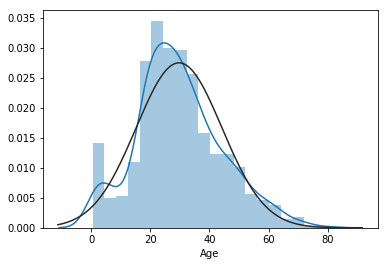

In [7]:
sns.distplot(train_df['Age'].dropna(), fit=norm)

Slightly skewed, so impute with median rather than mean.

Now look at Fare distribution.

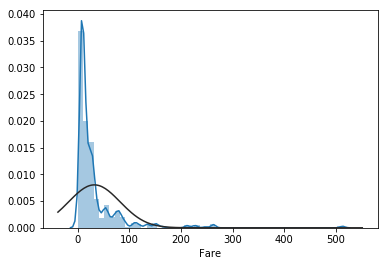

In [8]:
sns.distplot(train_df['Fare'].dropna(), fit=norm)

Quite heavily skewed. Try plotting distribution of logged values.

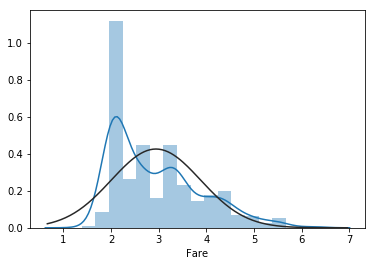

In [9]:
sns.distplot(np.log(train_df.loc[train_df.Fare > 0].Fare), fit=norm)

Still not great. Come back to this later, for now use median as above.

# Preparation
Prepare data for modelling based on exploration.

Extract title from Name field.

In [10]:
# Assume title contains full stop. If multiple full stops, assume first value is title.
train_df['Title'] = train_df.Name.apply(lambda x: [y for y in re.split('[,\s]', x) if '.' in y][0])
test_df['Title'] = test_df.Name.apply(lambda x: [y for y in re.split('[,\s]', x) if '.' in y][0])

# Replace least common titles with 'Other'
most_common_titles = dict(Counter(train_df.Title.values).most_common(4))
train_df['Title'] = train_df.Title.apply(lambda x: x if x in most_common_titles else 'Other')
test_df['Title'] = test_df.Title.apply(lambda x: x if x in most_common_titles else 'Other')

train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr.


Append HasCabin column for Cabin = Nan. Parse Cabin values to get letter and number.

In [11]:
def get_cabin_number(x):
    if str(x) == 'nan':
        # No cabin
        return -1
    else:
        # First cabin number (i.e. if multiple cabins)
        try:
            return int(re.findall('[0-9]+', x)[0])
        # No Number found
        except IndexError:
            return None
    
    
def get_cabin_letter(x):
    if str(x) == 'nan':
        return 'No%20Cabin'
    else:
        return str(x)[0]
    
    
def prepare_cabin(df):
    df['HasCabin'] = (~df.Cabin.isnull()).astype(int)
    df['CabinNumber'] = df.Cabin.apply(get_cabin_number)
    df['CabinLetter'] = df.Cabin.apply(get_cabin_letter)
    return df


train_df = prepare_cabin(train_df)
test_df = prepare_cabin(test_df)
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,HasCabin,CabinNumber,CabinLetter
PassengerId,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.,0,-1.0,No%20Cabin
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.,1,85.0,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.,0,-1.0,No%20Cabin
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.,1,123.0,C
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr.,0,-1.0,No%20Cabin


Impute remaining missing data: median for continuous variables and mode for catagorical.

In [12]:
# Thanks very much to: https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)
    
imputer = DataFrameImputer()
train_df = imputer.fit_transform(train_df)
test_df = imputer.transform(test_df)
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,HasCabin,CabinNumber,CabinLetter
PassengerId,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,G6,S,Mr.,0,-1.0,No%20Cabin
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.,1,85.0,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,G6,S,Miss.,0,-1.0,No%20Cabin
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.,1,123.0,C
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,G6,S,Mr.,0,-1.0,No%20Cabin


Encode categorical features to numerical labels.

In [13]:
# Fit encoder.
encode_cols = ['Sex', 'Embarked', 'Title', 'CabinLetter']
encoder = OrdinalEncoder()
encoder.fit(pd.concat([train_df, test_df], sort=False)[encode_cols])

# Encode
train_df[encode_cols] = encoder.transform(train_df[encode_cols])
test_df[encode_cols] = encoder.transform(test_df[encode_cols])

Bin continuous columns: Age and Fare.

In [14]:
# Age
train_df['Age'] = pd.qcut(train_df['Age'], 10, duplicates='drop', labels=False)
test_df['Age'] = pd.qcut(test_df['Age'], 10, duplicates='drop', labels=False)

# Fare
train_df['Fare'] = pd.qcut(train_df['Fare'], 10, duplicates='drop', labels=False)
test_df['Fare'] = pd.qcut(test_df['Fare'], 10, duplicates='drop', labels=False)

# Validation
Fit a model and validate.

In [15]:
feature_cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'HasCabin', 'CabinNumber', 'CabinLetter']
X = train_df[feature_cols].values
y = train_df.Survived

In [16]:
# Scoring function for cross-validation.
scorer = make_scorer(accuracy_score, greater_is_better=True)

# Grid search.
model = GradientBoostingClassifier(loss='deviance', criterion='friedman_mse', random_state=0, subsample=0.9)
param_grid = {
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 3, 4],
    'max_depth': [3, 4, 5],
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, refit=True, n_jobs=-1)
grid_search.fit(X, y)

print(f'Best accuracy: {grid_search.best_score_:.3f}')
print(f'Best estimator: {grid_search.best_estimator_}')

Best accuracy: 0.832
Best estimator: GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=0.9, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


# Prediction
Generate predictions using fitted model.

In [17]:
model = grid_search.best_estimator_
X_test = test_df[feature_cols].values
y_pred = model.predict(X_test)

# Submission
Create submission dataframe and save to csv.

In [18]:
samble_sub_df = pd.read_csv(data_path / 'gender_submission.csv')
samble_sub_df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [19]:
sub_df = pd.DataFrame({
    'PassengerId': test_df.index.values,
    'Survived': y_pred
})
sub_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [20]:
sub_df.to_csv('submission.csv', index=False)